In [145]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import re
from wordcloud import WordCloud


In [146]:
data_path = r"../data/processed/all_data_1.csv"

In [104]:
# load data into dataframe
df = pd.read_csv(data_path)
df.reset_index()
df = df.drop(df.columns[0], axis=1)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [105]:
display(df.head(7))
print("Total messages: ", len(df))
print("Total Characters: ", df['text'].str.len().sum())

,timedate,sender,text
0,"26.05.19, 13:14",Nimrod W,Dan cookson can dew if\n
1,"26.05.19, 13:14",Nimrod W,It\n
2,"26.05.19, 13:15",Alex Friend,Gotcha\n
3,"26.05.19, 13:15",Alex Friend,Will deliver\n
4,"26.05.19, 13:15",Nimrod W,Amazing\n
5,"26.05.19, 13:15",Nimrod W,This will change my life\n
6,"26.05.19, 13:15",Nimrod W,I will start a yt channel called 'oxidised br...


Total messages:  166314
Total Characters:  5104128


In [106]:
# let's have a little look at some of the stats
df[['sender','text']].groupby(['sender']).count().sort_values(by='text', ascending=False).head(18)

,text
sender,
Nimrod W,56500
Yoav Wynne,17378
Annika Guez,16218
Eytan Merkier,8246
Walt Trustam,7179
Avishai Wynne,6738
Scott Fielding,6542
Judy Peritz-Wynne (Mum),6537
Jonathan Wynne (Dad),4795


In [107]:
message_lengths = df['text'].str.len().to_list()
mean_len = np.mean(message_lengths)
print("Mean Message Length: ", np.round(mean_len))
print("Minumum and Maximum: ", np.min(message_lengths), ", ", np.max(message_lengths))
print("Median length: ", np.median(message_lengths))

Mean Message Length:  31.0
Minumum and Maximum:  3 ,  2947
Median length:  25.0


In [108]:
print(df.loc[df['text'].str.len() > 200])

               timedate          sender                                               text
1703    12.09.20, 00:52        Nimrod W   https//www.reddit.com/r/Cooking/comments/g7rw...
2749    27.01.20, 12:37  Daniel Cordell   מה לעזאזל פשוט אמרת עלי, כלבה קטנה? אוודע לך ...
2974    23.12.20, 01:01   Eytan Merkier   Tangent which wasn't completed due to my drun...
2976    23.12.20, 01:07   Eytan Merkier   I think this is just my personality/ characte...
2984    23.12.20, 09:04        Nimrod W   https//www.mitgaisim.idf.il/%D7%9B%D7%AA%D7%9...
...                 ...             ...                                                ...
157998  04.03.22, 08:10   Eytan Merkier   Nimrooodddd, happy birthday, enjoy the day wi...
160046  21.10.22, 12:41        Nimrod W   its the pantry closet, we let the situation g...
160782  14.12.22, 18:08        Nimrod W   שלום נמרוד.שוחחתי עם רוזלי. היא מתקיימת מדמי ...
161777  29.07.22, 13:00        Nimrod W   https//www.google.com/url?sa=t&source=web&rct...

In [109]:
# let's remove the newlines and some of whatsapps features
def remove_urls(line):
    line = re.sub(r'http\S+', '', line)
    return line
df['text'] = df['text'].map(lambda x: x.replace('\n', ''))
df['text'] = df['text'].map(lambda x: x.replace('<Medien ausgeschlossen>', ''))
df['text'] = df['text'].map(lambda x: remove_urls(x))

Here we see the distribution of message lengths. Plotting using a log scale we can see a that most messages there are a small minority of very long messages

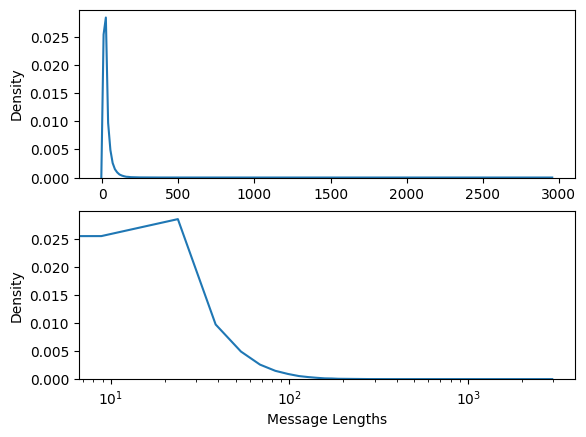

In [111]:
# let's have a look at the distributions of the message lengths
fig, ax = plt.subplots(2)
plt.xlabel("Message Lengths")
sns.kdeplot(message_lengths, ax=ax[0])
sns.kdeplot(message_lengths, ax=ax[1]) 
ax[1].set_xscale('log')
plt.show()

In [112]:
# let's have a look at the times that messages were sent at
# maybe hour of day vs number of messages?
# first, let's convert the datetime to a useable datetime object
def text_to_datetime(text):
    try:
        return datetime.strptime(text, "%d.%m.%y, %H:%M")
    except:
        return None
        
df_date = df.copy()
df_date['datetime'] = df_date.apply(lambda row: text_to_datetime(row['timedate']), axis=1)
print(df_date)

               timedate        sender                                          text            datetime
0       26.05.19, 13:14      Nimrod W                        Dan cookson can dew if 2019-05-26 13:14:00
1       26.05.19, 13:14      Nimrod W                                            It 2019-05-26 13:14:00
2       26.05.19, 13:15   Alex Friend                                        Gotcha 2019-05-26 13:15:00
3       26.05.19, 13:15   Alex Friend                                  Will deliver 2019-05-26 13:15:00
4       26.05.19, 13:15      Nimrod W                                       Amazing 2019-05-26 13:15:00
...                 ...           ...                                           ...                 ...
166309  16.01.23, 19:10      Nimrod W                                               2023-01-16 19:10:00
166310  16.01.23, 19:11  Inbar Hasson                                          Yeah 2023-01-16 19:11:00
166311  16.01.23, 19:11  Inbar Hasson                But isn't h

<AxesSubplot: xlabel='datetime'>

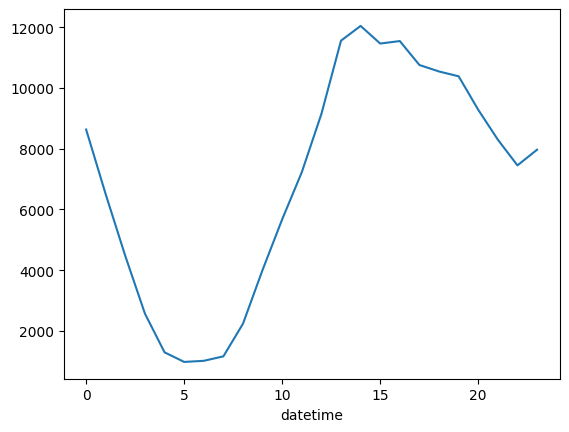

In [113]:
# here we have a plot of hour of the day versus number of messages sent. 
df_date.groupby(df_date['datetime'].dt.hour).count()['text'].plot()

In [114]:
# let's now look at the unique words in the data frame
unique = list(df['text'].str.split(" ", expand=True).stack().unique())

In [115]:
unique_word_counts = df['text'].str.split(' ', expand=True).stack().value_counts()

In [144]:
top_words = unique_word_counts.index.tolist()
print("No. Unique words: ", len(unique))

No. Unique words:  69663


In [150]:
wordcloud_all_senders = WordCloud(width=800, height=800,
                                    background_color ='white', stopwords=None,
                                    min_font_size=10, min_word_length=3).generate(' '.join(top_words[:500]))

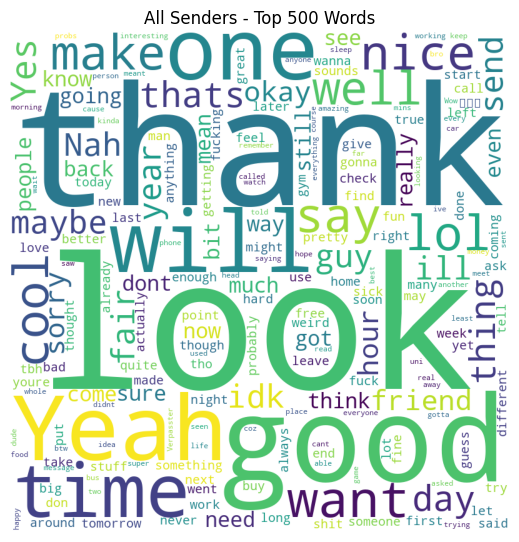

In [151]:
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud_all_senders)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("All Senders - Top 500 Words")
 
plt.show()

In [223]:
def create_word_cloud(sender, top_n_words=200):
    font_path = r"C:\Windows\Fonts\Arial.ttf"
    unique_words = df['text'].loc[df['sender'] == sender].str.split(" ", expand=True).stack().value_counts()
    unique_words = unique_words.index.tolist()
    wordcloud = WordCloud(width=800, height=800,
                          font_path=font_path,
                          background_color ='white', stopwords=None,
                          min_font_size=10, min_word_length=3).generate(' '.join(unique_words[:top_n_words]))
    return wordcloud

In [238]:
top_senders = df[['sender','text']].groupby(['sender']).count().sort_values(by='text', ascending=False)
top_senders = top_senders.index.tolist()[:10]

In [ ]:
# plot subplots of top senders: 
wordclouds = []
n_words = 500
for i, sender in enumerate(top_senders):
    wc = create_word_cloud(sender, n_words)
    wordclouds.append(wc)

In [ ]:
fig, ax = plt.subplots(int(len(top_senders)/2), 2, figsize=(30, 30))
# fig, ax = plt.subplots(int(len(top_senders)), figsize=(30, 30))

for i in range(2):
    for j in range(int(len(top_senders)/2)):
        ax[i, j].imshow(wc)
        ax[i, j].set_title(sender + " - Top " + str(n_words) + " words")
        ax[i, j].axis("off")
plt.show()